In [1]:
import numpy as np
from typing import List

import torch
import math
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import argparse
from tqdm import tqdm

from torch.utils.data import (Dataset, TensorDataset, DataLoader)
from torchvision import datasets
from torchvision.transforms import ToTensor

from source import *

Running on: cpu


# Set-up

In [2]:
# Step RelU
# Version for the eta in the definition of a radial rescaling activation

def stepReLU_eta(r):
    if r.shape == torch.Size([]):
        if r < 1:
            return 1e-6
        return r
    else:
        for i in range(len(r)):
            if r[i] < 1:
                r[i] = 1e-6
        return r

In [3]:
# Create uniform random noise in the unit d-ball
def generate_noise(m, r, d=28*28):
    '''m is the number of samples, r is the radius
    d is the total dimension, which is 28*28 for MNIST'''
    
    u = np.random.multivariate_normal(np.zeros(d),np.eye(d),m)  # an array of d normally distributed random variables
    norm=np.sum(u**2, axis = 1) **(0.5)
    norm = norm.reshape(m,1)
    rands = np.random.uniform(size=m)**(1.0/d)
    rands = rands.reshape(m,1)
    return r*rands*u/norm

# Note: need to do the following before adding to a sample:
# torch.tensor(generate_noise(m,radius,d)).reshape(m,1,28,28)

In [4]:
# Calculate distances
def smallest_distance(x: torch.tensor) -> float:
    radius = float('inf')
    for i in range(len(x)):
        for j in range(i):
            if torch.linalg.norm(x[i] - x[j]).item() < radius:
                radius = torch.linalg.norm(x[i] - x[j]).item()
    return radius

In [5]:
# Calculate distances
def shortest_distances(x: torch.tensor) -> list:
    result = []
    for i in range(len(x)):
        radius = float('inf')
        for j in range(i):
            if torch.linalg.norm(x[i] - x[j]).item() < radius:
                radius = torch.linalg.norm(x[i] - x[j]).item()
        for j in range(i+1,len(x)):
            if torch.linalg.norm(x[i] - x[j]).item() < radius:
                radius = torch.linalg.norm(x[i] - x[j]).item()
        result.append(radius)
    return result

In [6]:
shortest_distances(torch.tensor([3.,5.,9.,29., 2.5]))

[0.5, 2.0, 4.0, 20.0, 0.5]

# Get MNIST

In [7]:
mnist_dataset = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

In [8]:
batch_size = 256
train_dataloader = DataLoader(mnist_dataset, batch_size, shuffle=True)

In [9]:
len(mnist_dataset)

60000

In [10]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

if False:
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(img, cmap="gray")
    plt.show()
    print(f"Label: {label}")

Feature batch shape: torch.Size([256, 1, 28, 28])
Labels batch shape: torch.Size([256])


# Select threes and add noise

In [11]:
def add_noise(label=None, n=5, m=100, noise_scale=0.5, noise_type='ball', use_labels=False, verbose=False):
    '''label is one of 0,1,2,3,4,5,6,7,8,9;
    n is the number of original images; 
    m is the number of noisy samples per original image;
    may want to make the 2.5 definition of the radius into a hyperparameter
    '''
    
    batch_size = n * (1 if label is None else 20)
    train_dataloader = DataLoader(mnist_dataset, batch_size, shuffle=True)
    train_features, train_labels = next(iter(train_dataloader))

    # Get a selection of data with the same label, crop it to size n
    if label is not None:
        which = train_labels == label
        selection = train_features[which]
        labels    = train_labels[which]
    else:
        selection = train_features
        labels    = train_labels
    # randomly pick n elements
    which = torch.randperm(len(selection))[:n]
    selection = selection[which]
    labels    = labels[which]
    #selection = selection[:n]
    assert selection.shape[0] == n, "Too few of this label; take another batch"
    if verbose:
        plt.imshow(selection[2].squeeze(), cmap="gray")
        plt.show()
    
    #global radii, noise, noise_samples, noisy_labels
    radii = shortest_distances(selection)
    if noise_type == 'ball':
        noise = torch.tensor(generate_noise(m,r=1,d=28*28)).reshape(m,1,28,28)
    elif noise_type == 'normal':
        noise = torch.randn((m,1,28,28)) / np.sqrt(28*28)
    else:
        raise Exception(f'Unknown noise_type: {noise_type}')
    
    noisy_samples = torch.Tensor(torch.Size([int(n*m), 1, 28, 28]))
    noisy_labels = torch.Tensor(torch.Size([n*m])).to(torch.int64)
    for i in range(n):
        radius = radii[i] * noise_scale
        #print(f'Radius: {radius}')
        assert radius > 1e-6, "some samples are too close together"
        for j in range(m):
            noisy_samples[i*m + j] = selection[i] + radius*noise[j]
            if use_labels:
                label = labels[i]
            else:
                label = i
            noisy_labels[i*m + j] = label
    if use_labels:
        num_classes = 10
    else:
        num_classes = n
    noisy_labels = torch.nn.functional.one_hot(noisy_labels, num_classes).to(torch.float32)
    
    if verbose:
        plt.imshow(selection[0][0], cmap="gray")
        plt.show()
        plt.imshow(noisy_samples[0][0], cmap="gray")
        plt.show()
        plt.imshow(noisy_samples[1][0], cmap="gray")
    
    return noisy_samples, noisy_labels

def noisy_mnist_dataset(device=None, **kwargs):
    noisy_samples, noisy_labels = add_noise(**kwargs)
    return TensorDataset(noisy_samples.flatten(1).to(device), noisy_labels.to(device))

# Alternative for the labels:
# torch.eye(n).repeat_interleave(m, dim=0)

In [12]:
if False:
    print('Enter the number of original images:')
    num_samples = input()

    print('Enter the number of noisy copies of each:')
    m_copies = input()

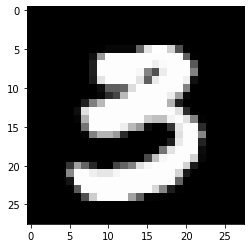

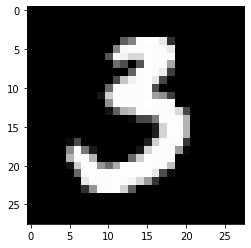

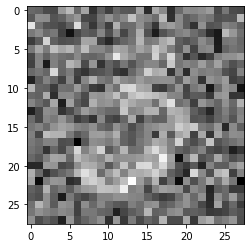

torch.Size([50, 1, 28, 28]) torch.Size([50, 5])


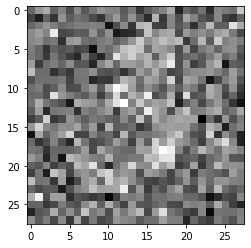

In [13]:
num_samples = 5
m_copies = 10

noisy_threes, noisy_labels = add_noise(label=3, n=int(num_samples), m=int(m_copies), verbose = True, noise_scale=2, noise_type='normal')
print(noisy_threes.shape, noisy_labels.shape)

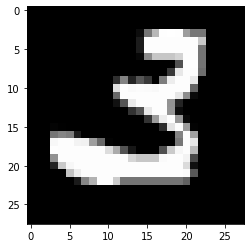

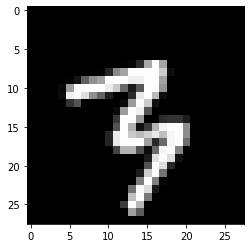

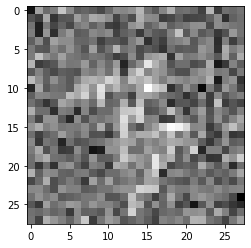

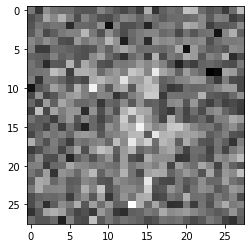

In [14]:
noisy_threes, noisy_labels = add_noise(label=3, n=int(num_samples), m=int(m_copies), verbose = True, noise_scale=2, noise_type='ball')


In [15]:
noisy_threes_flat = noisy_threes.flatten(1)

In [16]:
data = noisy_mnist_dataset()
loader = DataLoader(data, batch_size=len(data))
for x,y in loader:
    print(x.shape, y.shape)

torch.Size([500, 784]) torch.Size([500, 5])


# Train radnet with the noise

In [17]:
device = torch.device('cpu')

In [18]:
d=28*28
dim_vector = [d, d+1, d+2, d+3, num_samples]

# torch.sigmoid

In [ ]:
%%time

radnet = RadNet(eta=stepReLU_eta, dims=dim_vector, has_bias=False).to('cpu')
model_trained, model_losses = training_loop(
    n_epochs = 2000, 
    learning_rate = 0.05,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = noisy_threes_flat,
    y_train = noisy_labels,
    verbose=True)

In [ ]:
%%time
device = torch.device('cpu')
#device = torch.device('cuda')
print(f'Running on {device}')
radnet = RadNet(eta=stepReLU_eta, dims=dim_vector, has_bias=False).to(device)
model_trained, model_losses = training_loop(
    n_epochs = 2000, 
    learning_rate = 0.05,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = noisy_threes_flat.to(device),
    y_train = noisy_labels.to(device),
    verbose=True)

# Train ReLU net with noise

In [19]:
relu_net = torch.nn.Sequential(
    torch.nn.Linear(28*28, dim_vector[1]),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_vector[1], dim_vector[2]),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_vector[2], dim_vector[3]),
    torch.nn.ReLU(),
    torch.nn.Linear(dim_vector[3],num_samples)
    )
print(relu_net)

Sequential(
  (0): Linear(in_features=784, out_features=785, bias=True)
  (1): ReLU()
  (2): Linear(in_features=785, out_features=786, bias=True)
  (3): ReLU()
  (4): Linear(in_features=786, out_features=787, bias=True)
  (5): ReLU()
  (6): Linear(in_features=787, out_features=5, bias=True)
)


In [ ]:
relu_model_trained, relu_model_losses = training_loop(
    n_epochs = 2000, 
    learning_rate = 0.05,
    model = relu_net,
    params = list(relu_net.parameters()),
    x_train = noisy_threes_flat,
    y_train = noisy_labels,
    verbose=True)

In [ ]:
plt.plot(torch.tensor(model_losses).detach())
plt.plot(torch.tensor(relu_model_losses).detach())

In [20]:
def test(model, test_data, loss_fn=torch.nn.CrossEntropyLoss()):
    with torch.no_grad():
        loss_sum = 0.0
        accuracy_sum = 0.0
        for x, y in test_data:
            y_pred = model(x) 
            loss = loss_fn(y_pred, y)
            pred_class = torch.argmax(y_pred, dim=1)
            actual_class = torch.argmax(y, dim=1)
            accuracy = torch.mean((pred_class == actual_class).to(float))
            loss_sum += loss.detach().cpu()
            accuracy_sum += accuracy.detach().cpu()
        return loss_sum, accuracy_sum
            
def training_loop(n_epochs, learning_rate, model, train_data, test_data=None, verbose=True, loss_fn=torch.nn.CrossEntropyLoss()):
    model.train(True)
    losses = []
    accuracies = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(1, n_epochs + 1):
        loss_sum = 0.0
        accuracy_sum = 0.0
        for x, y in train_data:
            optimizer.zero_grad()
        
            y_pred = model(x) 
            loss = loss_fn(y_pred, y)
            
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                pred_class = torch.argmax(y_pred, dim=1)
                actual_class = torch.argmax(y, dim=1)
                accuracy = torch.mean((pred_class == actual_class).to(float))
                loss_sum += loss.detach().cpu()
                accuracy_sum += accuracy.detach().cpu()
        
        losses.append(loss_sum)
        accuracies.append(accuracy_sum)
        if verbose:
            if epoch ==1 or epoch % 500 == 0:
                if test_data is not None:
                    test_loss, test_accuracy = test(model, test_data)
                print('Epoch %d, Loss %f, Accuracy %f, Test loss %f, Test accuracy %f' % (epoch, loss_sum, accuracy_sum, test_loss, test_accuracy))

    return {'model':model, 'loss':losses, 'accuracy':accuracies}

In [21]:
def ReLUNet(dims):
    """Build a ReLU network with the given layer sizes. There is a ReLU between each pair of linear layers."""
    layers = []
    for i in range(len(dims) - 1):
        layers.append(torch.nn.Linear(dims[i], dims[i+1]))
        if i+1 < len(dims):
            layers.append(torch.nn.ReLU())
    return torch.nn.Sequential(*layers)

In [22]:
def train_both(num_samples, m_copies, dim_vector=None, label=3, device=device, batch_size=None, epochs=2000, loss_fn=torch.nn.CrossEntropyLoss(), train_fraction=0.8, **kwargs):
    data = noisy_mnist_dataset(label=None, n=int(num_samples), m=int(m_copies),
                               verbose=False, device=device, **kwargs)
    #noisy_threes, noisy_labels = add_noise(label=3, n=int(num_samples), m=int(m_copies),
    #                                       verbose=False, noise_scale=noise_scale, noise_type=noise_type)
    #noisy_threes_flat = noisy_threes.flatten(1).to(device)
    #noisy_labels = noisy_labels.to(device)
    num_train = int(len(data)*train_fraction)
    train_data, test_data = torch.utils.data.random_split(data, [num_train, len(data)- num_train])
    if batch_size is None:
        batch_size = len(train_data)
    train_loader = DataLoader(train_data, batch_size=batch_size)
    test_loader  = DataLoader(test_data, batch_size=len(test_data))
    num_classes = next(iter(train_data))[1].shape[-1]
    if dim_vector is None:
        dim_vector= [28*28, 28*28 + 1, 28*28 + 2, num_classes]
    
    print('')
    print('### Data description')
    print('number or original images =', num_samples)
    print('number of copies of each =', m_copies)
    print('number of classes =', num_classes)
    print('number or samples =', len(train_data),"train,", len(test_data),"test")
    print('dimension vector =', dim_vector)
    print('')
    
    print('#### Training stepReLU radnet:')
    radnet = RadNet(eta=stepReLU_eta, dims=dim_vector, has_bias=False).to(device)
    log = training_loop(
        n_epochs = epochs, 
        learning_rate = 0.01,
        model = radnet,
        train_data=train_loader,
        test_data=test_loader,
        loss_fn = loss_fn,
        verbose=True)
    
    print('')
    print('#### Training ReLU MLP:')
    relu_net = ReLUNet(dim_vector).to(device)
    relu_log = training_loop(
        n_epochs = epochs, 
        learning_rate = 0.01,
        model = relu_net,
        train_data=train_loader,
        test_data=test_loader,
        loss_fn = loss_fn,
        verbose=True)
    
    return

In [23]:
train_both(
    num_samples = 500,
    m_copies = 1,
    noise_scale = 1.0,
    noise_type = 'normal',
    epochs = 5000,
    #loss_fn = torch.nn.MSELoss()
    use_labels = True,
    batch_size = 100,
    #dim_vector = [784, 785, 10]
)


### Data description
number or original images = 500
number of copies of each = 1
number of classes = 10
number or samples = 400 train, 100 test
dimension vector = [784, 785, 786, 10]

#### Training stepReLU radnet:


RuntimeError: 1D target tensor expected, multi-target not supported

In [ ]:
train_both(
    num_samples = 500,
    m_copies = 10,
    noise_scale = 1.0,
    noise_type = 'normal',
    #loss_fn = torch.nn.MSELoss()
    use_labels = True,
)

In [ ]:
ns = [3,4,5]
ms = [100,500,1000]
d= 28*28
dim_vecs = [
    [d, d+1, d+2, d+3, 1],
    [d, d+1, d+2, d+3, d+4, 1],
    [d, d+1, d+2, d+3, d+4, d+5, 1]]

In [ ]:

if False:
    for i in range(len(n)):
        for m in ms:
            train_both(
                num_samples = n[i],
                m_copies = m,
                dim_vector= dims[i])
            


# Network for learning all of MNIST

In [ ]:
train_features_flat = train_features.flatten(1)
train_features_flat.shape

In [ ]:
radnet = RadNet(eta=torch.sigmoid, dims=[28*28,28*28, 28 , 28,1], has_bias=False)

In [ ]:
model_trained, model_losses = training_loop(
    n_epochs = 3000, 
    learning_rate = 0.05,
    model = radnet,
    params = list(radnet.parameters()),
    x_train = train_features_flat,
    y_train = train_labels,
    verbose=True)

# Scraps

In [ ]:
# Calculate distances
radius = float('inf')
for i in range(n):
    for j in range(i+1,n):
        if torch.linalg.norm(threes[i] - threes[j]).item() < radius:
            radius = torch.linalg.norm(threes[i] - threes[j]).item()
radius = radius/2.5
radius

In [ ]:
noisy_threes = torch.Tensor(torch.Size([int(n*m), 1, 28, 28]))
noisy_labels = torch.Tensor(torch.Size([n*m, n]))
for i in range(n):
    for j in range(m):
        noisy_threes[i*n + j]= threes[i] + noise[j]   
        noisy_labels[i*m + j]=  torch.eye(n)[i]
        


if False:
    print(noisy_threes.shape, noisy_labels.shape)
if False:
    plt.imshow(threes[0][0], cmap="gray")
    plt.show()
    plt.imshow(noisy_threes[0][0], cmap="gray")
    plt.show()
    plt.imshow(noisy_threes[1][0], cmap="gray")